<a href="https://colab.research.google.com/github/Kim-Jeong-Ju/AI_Modeling_Computer_Vision/blob/main/EfficientNet_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Drive Mount and Packages/Modules Importation**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
import time
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

from collections import OrderedDict

import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms

from torchsummary import summary

device = "cuda" if torch.cuda.is_available() else "cpu"
device

Mounted at /content/drive


'cuda'

# **※ Dataset Preparation**

###**CIFAR-10 Dataset** -- *32 X 32 pixels RGB Color images* with 10 class labels  
0(비행기), 1(자동차), 2(새), 3(고양이), 4(사슴), 5(개), 6(개구리), 7(말), 8(배), 9(트럭)

Files already downloaded and verified
Files already downloaded and verified
Train Data Length : 50000
# of Class Labels : [0 1 2 3 4 5 6 7 8 9]


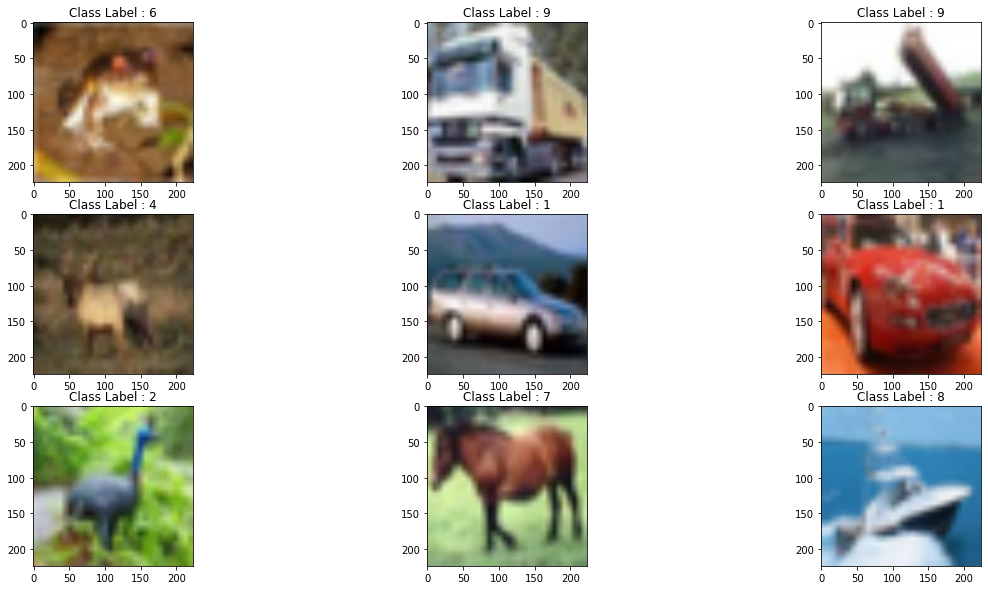

In [2]:
## Define Dataset Root Path and Transforms
root = os.path.join(os.getcwd(), "drive", "MyDrive", "Colab Notebooks", "AI Algorithm Modeling", "data")

apply_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


## Get CIFAR-10 Image Dataset
train_data = torchvision.datasets.CIFAR10(
    root=root,
    train=True,
    download=True,
    transform=apply_transform
)

test_data = torchvision.datasets.CIFAR10(
    root=root,
    train=False,
    download=True,
    transform=apply_transform
)


## Define Image Plot function
def sample_img_show(data, figsize=(20, 10)):
    fig = plt.figure(figsize=figsize)
    for i in range(9):
        image = data[i][0]
        ax = fig.add_subplot(3, 3, i+1)
        ax.imshow(image.permute(1, 2, 0))
        ax.set_title(f"Class Label : {data[i][1]}")
    fig.show()


## Check CIFAR-10 Dataset
print(f"Train Data Length : {len(train_data.targets)}")
print(f"# of Class Labels : {np.unique(train_data.targets)}")
sample_img_show(data=train_data)

###**Training / Validation Dataset Split**

In [3]:
## Training / Validation Dataset Split with random_split
random_seed = 0
torch.manual_seed(random_seed)

valid_size = int(len(train_data) * 0.2)
train_size = len(train_data) - valid_size
train_data, valid_data = random_split(train_data, [train_size, valid_size])

print(f"Training Dataset : {len(train_data)}")
print(f"Validation Dataset : {len(valid_data)}")
print()

print(train_data[0][0].shape)

Training Dataset : 40000
Validation Dataset : 10000

torch.Size([3, 224, 224])


###**Definition of DataLoader Class**

In [4]:
## Definition of DataLoader Class
train_loader = DataLoader(dataset=train_data, batch_size=50, shuffle=True, drop_last=True)
valid_loader = DataLoader(dataset=valid_data, batch_size=50, shuffle=True, drop_last=True)
test_loader = DataLoader(dataset=test_data, batch_size=50, shuffle=False, drop_last=False)

loaders = {}
loaders["train"] = train_loader
loaders["valid"] = valid_loader
loaders["test"] = test_loader

print(f"Train Loader Length = {len(train_loader)},  Valid Loader Length = {len(valid_loader)},  Test Loader Length = {len(test_loader)}")

Train Loader Length = 800,  Valid Loader Length = 200,  Test Loader Length = 200


# <font color="#FF0000"> **※ EfficientNet v1 Model and Actuator Definition** </font>

### <font color="#FF0000"> **① Architecture of EfficientNet v1 Model with MBConv,  SepConv and SE Block** </font>

In [7]:
## EfficientNet v1 Model with MBConv, SepConv and SE Block
class EfficientNetv1(nn.Module):
    def __init__(self, n_class=10):
        super().__init__()                                                                                  # Input Image Tensor = 3 X 224 X 224
        
        self.input_block = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1),                  # ① Advanced Input Conv Block = 32 X 112 X 112
            nn.BatchNorm2d(32),
            nn.ReLU6()
        )

        self.a_block = mb_conv(in_channels=32, out_channels=16, scale=1, kernel_size=3, stride=1)           # ② A_MBConv Block = 16 X 112 X 112

        self.b_block = nn.Sequential(                                                                       # ③ B_MBConv Block = 40 X 28 X 28
            mb_conv(in_channels=16, out_channels=16, scale=6, kernel_size=3, stride=2),
            mb_conv(in_channels=16, out_channels=24, scale=6, kernel_size=3, stride=1),

            mb_conv(in_channels=24, out_channels=24, scale=6, kernel_size=5, stride=2),
            mb_conv(in_channels=24, out_channels=40, scale=6, kernel_size=5, stride=1)
        )

        self.c_block = nn.Sequential(                                                                       # ④ C_MBConv Block = 112 X 14 X 14
            mb_conv(in_channels=40, out_channels=40, scale=6, kernel_size=3, stride=2),
            mb_conv(in_channels=40, out_channels=40, scale=6, kernel_size=3, stride=1),
            mb_conv(in_channels=40, out_channels=80, scale=6, kernel_size=3, stride=1),

            mb_conv(in_channels=80, out_channels=80, scale=6, kernel_size=5, stride=1),
            mb_conv(in_channels=80, out_channels=80, scale=6, kernel_size=5, stride=1),
            mb_conv(in_channels=80, out_channels=112, scale=6, kernel_size=5, stride=1)
        )

        self.d_block = nn.Sequential(                                                                       # ⑤ D_MBConv Block = 320 X 7 X 7
            mb_conv(in_channels=112, out_channels=112, scale=6, kernel_size=5, stride=2),
            mb_conv(in_channels=112, out_channels=112, scale=6, kernel_size=5, stride=1),
            mb_conv(in_channels=112, out_channels=112, scale=6, kernel_size=5, stride=1),
            mb_conv(in_channels=112, out_channels=192, scale=6, kernel_size=5, stride=1),

            mb_conv(in_channels=192, out_channels=320, scale=6, kernel_size=3, stride=1)
        )

        self.output_block = nn.Sequential(                                                                  # ⑥ Advanced Output Conv Block = 10 Vectorize
            nn.Conv2d(in_channels=320, out_channels=640, kernel_size=3, stride=1),
            nn.BatchNorm2d(640),
            nn.Hardswish(),

            nn.Conv2d(in_channels=640, out_channels=1280, kernel_size=3, stride=1),
            nn.BatchNorm2d(1280),
            nn.Hardswish(),

            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),

            nn.Linear(in_features=1280, out_features=256),
            nn.BatchNorm1d(256),
            nn.ReLU(),

            nn.Linear(in_features=256, out_features=n_class)
        )

    def forward(self, input):
        temp1 = self.input_block(input)
        temp2 = self.a_block(temp1)
        temp3 = self.b_block(temp2)
        temp4 = self.c_block(temp3)
        temp5 = self.d_block(temp4)
        output = self.output_block(temp5)

        return output


## Advanced MBConv in EfficientNet v1 Model
class mb_conv(nn.Module):
    def __init__(self, in_channels, out_channels, scale, kernel_size, stride):
        super().__init__()

        self.padding = kernel_size // 2
        self.mid_channels = int(in_channels * scale)
        
        self.input_conv = nn.Sequential(                                # ① Advanced Input Conv Block of MBConv with ReLU6
            nn.Conv2d(in_channels=in_channels, out_channels=self.mid_channels, kernel_size=1, stride=1),
            nn.BatchNorm2d(self.mid_channels),
            nn.ReLU6()
        )

        self.depthwise = nn.Sequential(                                 # ② Advanced Depth-wise Convolutional Block of MBConv with ReLU6
            nn.Conv2d(in_channels=self.mid_channels, out_channels=self.mid_channels, kernel_size=kernel_size, stride=stride, padding=self.padding, groups=self.mid_channels),
            nn.BatchNorm2d(self.mid_channels),
            nn.ReLU6()
        )

        self.se_block = se_block(channels=self.mid_channels)            # ③ Squeeze and Excitation Block of MBConv with ReLU + H-Swish

        self.output_conv = nn.Sequential(                               # ④ Output Conv Block of MBConv
            nn.Conv2d(in_channels=self.mid_channels, out_channels=out_channels, kernel_size=1, stride=1),
            nn.BatchNorm2d(out_channels)
        )

        self.adjust_channel = nn.Sequential(                            # Adjustment Block for Different Channel Dimension with H-Swish
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1),
            nn.BatchNorm2d(out_channels),
            nn.Hardswish()
        )

        self.adjust_size = nn.Sequential(                               # Adjustment Block for Different Feature Map Size with H-Swish
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.Hardswish()
        )

    def forward(self, input):
        temp1 = self.input_conv(input)
        temp2 = self.depthwise(temp1)
        temp3 = self.se_block(temp2)
        temp4 = self.output_conv(temp3)

        if input.size(1) != temp4.size(1):
            input = self.adjust_channel(input)
        elif input.size(2) != temp4.size(2) and input.size(3) != temp4.size(3):
            input = self.adjust_size(input)

        output = input + temp4                      # Skip-Connection with Residual Learning

        return output


## SE Block for Squeeze and Excitation Process in EfficientNet v1 Model
class se_block(nn.Module):
    def __init__(self, channels, ratio=16):
        super().__init__()

        self.squeeze = nn.AdaptiveAvgPool2d(1)                                          # ① Squeeze Process of SE Algorithm : Global Average Pooling to 1X1 Feature map

        self.excitation = nn.Sequential(                                                # ② Excitation Process of SE Algorithm : Fully-Connected Operation with ReLU and H-Swish
            nn.Flatten(),
            
            nn.Linear(in_features=channels, out_features=int(channels/ratio)),
            nn.ReLU(),
            nn.Linear(in_features=int(channels/ratio), out_features=channels),
            nn.Hardswish(),
        )
    
    def forward(self, input):
        temp = self.excitation(self.squeeze(input))
        contribute = temp.view(temp.size(0), temp.size(1), 1, 1)
        output = torch.mul(input, contribute)

        return output


efficientnetv1_sample = EfficientNetv1(n_class=10).to(device)           # EfficientNet v1 Model for Sample Version
summary(efficientnetv1_sample, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             896
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           1,056
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 32, 112, 112]             320
       BatchNorm2d-8         [-1, 32, 112, 112]              64
             ReLU6-9         [-1, 32, 112, 112]               0
AdaptiveAvgPool2d-10             [-1, 32, 1, 1]               0
          Flatten-11                   [-1, 32]               0
           Linear-12                    [-1, 2]              66
             ReLU-13                    [-1, 2]               0
           Linear-14                   

### <font color="#FF0000"> **② Actuator(Trainer/Tester) Construction for EfficientNet v1** </font>

In [8]:
## EfficientNet v1 Actuator Definition
class EfficientNetv1_Actuator(nn.Module):
    def __init__(self, model, loaders, opt="sgd", lr=0.01, has_scheduler=False, device="cuda"):
        super().__init__()

        self.model = model
        self.loss = nn.CrossEntropyLoss()

        self.train_loader = loaders["train"]
        self.valid_loader = loaders["valid"]
        self.test_loader = loaders["test"]

        self._get_optimizer(opt=opt.lower(), lr=lr)
        self.has_scheduler = has_scheduler
        if self.has_scheduler:
            self._get_scheduler()

        self.device = device
    
    def _get_optimizer(self, opt="sgd", lr=0.01):
        if opt == "sgd":
            self.optimizer = torch.optim.SGD(params=self.model.parameters(), lr=lr, momentum=0.9, weight_decay=0.0001)
        elif opt == "adagrad":
            self.optimizer = torch.optim.Adagrad(params=self.model.parameters(), lr=lr)
        elif opt == "adadelta":
            self.optimizer = torch.optim.Adadelta(params=self.model.parameters(), lr=lr)
        elif opt == "rmsprop":
            self.optimizer = torch.optim.RMSprop(params=self.model.parameters(), lr=lr)
        elif opt == "adam":
            self.optimizer = torch.optim.Adam(params=self.model.parameters(), lr=lr)
        else:
            raise ValueError(f"Inputted Optimizer {opt} is not Supported")
    
    def _get_scheduler(self):
        self.scheduler = torch.optim.lr_scheduler.StepLR(optimizer=self.optimizer, step_size=10, gamma=0.3, verbose=True)    # 학습의 총 epoch에서 step_size마다 gamma의 비율로 learning rate를 순차적으로 줄임
        # self.scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=self.optimizer, lr_lambda=lambda epoch: 0.95**epoch)   # 학습 도중 lr_lambda에 정의한 function에 의해 learning rate을 순차적으로 줄임
    
    def train_and_valid(self, max_epochs=10, disp_epochs=1):
        print("========== Train and Valid Start ==========")
        start_time = time.time()

        history = {"Train_Loss" : [], "Train_Acc" : [], "Valid_Loss" : [], "Valid_Acc" : []}

        for epoch in tqdm(range(max_epochs), desc="Training Process..."):
            train_loss, train_acc = self._train_epoch()
            valid_loss, valid_acc = self._valid_epoch()

            history["Train_Loss"].append(train_loss)
            history["Train_Acc"].append(train_acc)
            history["Valid_Loss"].append(valid_loss)
            history["Valid_Acc"].append(valid_acc)

            if self.has_scheduler:
                self.scheduler.step()
            
            if epoch % disp_epochs == 0:
                print(f"{epoch+1}/{max_epochs} Epoch ==> Train Loss : {train_loss:>6f}, Train Acc : {train_acc:>6f}, Valid Loss : {valid_loss:>6f}, Valid Acc : {valid_acc:>6f}, Time : {time.time() - start_time:>3f}")
                start_time = time.time()
        
        self.plot_history(history)
    
    def _train_epoch(self):
        train_epoch_loss, train_epoch_acc = 0, 0
        self.model.train()

        for (a, b) in self.train_loader:
            a = a.to(device=self.device)
            b = b.to(device=self.device)

            b_hat = self.model(a)
            loss = self.loss(b_hat, b)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            train_epoch_loss += loss.to("cpu").item()
            train_epoch_acc += (b_hat.argmax(1) == b).type(torch.float).to("cpu").mean().item()
        
        train_epoch_loss /= len(self.train_loader)
        train_epoch_acc /= len(self.train_loader)

        return train_epoch_loss, train_epoch_acc
    
    def _valid_epoch(self):
        valid_epoch_loss, valid_epoch_acc = 0, 0
        self.model.eval()

        with torch.no_grad():
            for (a, b) in self.valid_loader:
                a = a.to(device=self.device)
                b = b.to(device=self.device)

                b_hat = self.model(a)
                loss = self.loss(b_hat, b)

                valid_epoch_loss += loss.to("cpu").item()
                valid_epoch_acc += (b_hat.argmax(1) == b).type(torch.float).to("cpu").mean().item()
        
        valid_epoch_loss /= len(self.valid_loader)
        valid_epoch_acc /= len(self.valid_loader)

        return valid_epoch_loss, valid_epoch_acc
    
    def plot_history(self, history):
        fig = plt.figure(figsize=(20, 10))

        ax = fig.add_subplot(1, 2, 1)
        ax.plot(history["Train_Loss"], color="red", label="Train Loss")
        ax.plot(history["Valid_Loss"], color="orange", label="Valid Loss")
        ax.set_title("Loss")
        ax.legend()

        ax = fig.add_subplot(1, 2, 2)
        ax.plot(history["Train_Acc"], color="red", label="Train Accuracy")
        ax.plot(history["Valid_Acc"], color="orange", label="Valid Accuracy")
        ax.set_title("Accuracy")
        ax.legend()

        fig.show()
    
    def test(self):
        print("========== Test Start ==========")
        start_time = time.time()

        test_epoch_loss, test_epoch_acc = 0, 0
        self.model.eval()

        with torch.no_grad():
            for (a, b) in self.test_loader:
                a = a.to(device=self.device)
                b = b.to(device=self.device)

                b_hat = self.model(a)
                loss = self.loss(b_hat, b)

                test_epoch_loss += loss.to("cpu").item()
                test_epoch_acc += (b_hat.argmax(1) == b).type(torch.float).to("cpu").mean().item()
        
        test_epoch_loss /= len(self.test_loader)
        test_epoch_acc /= len(self.test_loader)

        print(f"Test loss: {test_epoch_loss:>6f}, Test acc: {test_epoch_acc:>3f}, Test time : {time.time() - start_time:>3f}")

# <font color="#FFBB00"> **※ Training / Validating / Testing** </font>

========== Train and Valid Start ==========


Training Process...:   5%|▌         | 1/20 [04:39<1:28:23, 279.11s/it]

1/20 Epoch ==> Train Loss : 1.909555, Train Acc : 0.252575, Valid Loss : 1.695059, Valid Acc : 0.360400, Time : 279.120852


Training Process...:  10%|█         | 2/20 [09:17<1:23:32, 278.50s/it]

2/20 Epoch ==> Train Loss : 1.428594, Train Acc : 0.470150, Valid Loss : 1.251918, Valid Acc : 0.547900, Time : 278.070530


Training Process...:  15%|█▌        | 3/20 [13:56<1:18:57, 278.66s/it]

3/20 Epoch ==> Train Loss : 1.187949, Train Acc : 0.572800, Valid Loss : 1.233943, Valid Acc : 0.548400, Time : 278.857370


Training Process...:  20%|██        | 4/20 [18:35<1:14:24, 279.03s/it]

4/20 Epoch ==> Train Loss : 1.039075, Train Acc : 0.628850, Valid Loss : 0.936208, Valid Acc : 0.673200, Time : 279.601102


Training Process...:  25%|██▌       | 5/20 [23:13<1:09:40, 278.70s/it]

5/20 Epoch ==> Train Loss : 0.901631, Train Acc : 0.684700, Valid Loss : 0.936548, Valid Acc : 0.671900, Time : 278.098922


Training Process...:  30%|███       | 6/20 [27:52<1:05:01, 278.66s/it]

6/20 Epoch ==> Train Loss : 0.770580, Train Acc : 0.731975, Valid Loss : 0.754217, Valid Acc : 0.735700, Time : 278.599484


Training Process...:  35%|███▌      | 7/20 [32:31<1:00:23, 278.71s/it]

7/20 Epoch ==> Train Loss : 0.688055, Train Acc : 0.761325, Valid Loss : 0.716525, Valid Acc : 0.752900, Time : 278.801697


Training Process...:  40%|████      | 8/20 [37:09<55:42, 278.52s/it]  

8/20 Epoch ==> Train Loss : 0.594138, Train Acc : 0.793425, Valid Loss : 0.671419, Valid Acc : 0.768500, Time : 278.110939


Training Process...:  45%|████▌     | 9/20 [41:47<51:01, 278.34s/it]

9/20 Epoch ==> Train Loss : 0.524668, Train Acc : 0.819225, Valid Loss : 0.606910, Valid Acc : 0.790700, Time : 277.941324


Training Process...:  50%|█████     | 10/20 [46:25<46:23, 278.34s/it]

10/20 Epoch ==> Train Loss : 0.461419, Train Acc : 0.839375, Valid Loss : 0.593706, Valid Acc : 0.799100, Time : 278.342578


Training Process...:  55%|█████▌    | 11/20 [51:03<41:45, 278.35s/it]

11/20 Epoch ==> Train Loss : 0.422268, Train Acc : 0.854625, Valid Loss : 0.634857, Valid Acc : 0.792100, Time : 278.369903


Training Process...:  60%|██████    | 12/20 [55:43<37:09, 278.68s/it]

12/20 Epoch ==> Train Loss : 0.370563, Train Acc : 0.869600, Valid Loss : 0.579587, Valid Acc : 0.812600, Time : 279.430055


Training Process...:  65%|██████▌   | 13/20 [1:00:21<32:29, 278.54s/it]

13/20 Epoch ==> Train Loss : 0.338897, Train Acc : 0.883600, Valid Loss : 0.644943, Valid Acc : 0.791900, Time : 278.218539


Training Process...:  70%|███████   | 14/20 [1:05:00<27:52, 278.75s/it]

14/20 Epoch ==> Train Loss : 0.296943, Train Acc : 0.896625, Valid Loss : 0.579276, Valid Acc : 0.817500, Time : 279.251817


Training Process...:  75%|███████▌  | 15/20 [1:09:39<23:14, 278.81s/it]

15/20 Epoch ==> Train Loss : 0.276812, Train Acc : 0.902725, Valid Loss : 0.536249, Valid Acc : 0.828700, Time : 278.947075


Training Process...:  80%|████████  | 16/20 [1:14:18<18:34, 278.72s/it]

16/20 Epoch ==> Train Loss : 0.239446, Train Acc : 0.915625, Valid Loss : 0.539583, Valid Acc : 0.834200, Time : 278.512052


Training Process...:  85%|████████▌ | 17/20 [1:18:56<13:55, 278.66s/it]

17/20 Epoch ==> Train Loss : 0.217950, Train Acc : 0.923100, Valid Loss : 0.582499, Valid Acc : 0.825900, Time : 278.522535


Training Process...:  90%|█████████ | 18/20 [1:23:35<09:17, 278.59s/it]

18/20 Epoch ==> Train Loss : 0.198943, Train Acc : 0.931050, Valid Loss : 0.622538, Valid Acc : 0.817000, Time : 278.434815


Training Process...:  95%|█████████▌| 19/20 [1:28:13<04:38, 278.51s/it]

19/20 Epoch ==> Train Loss : 0.178816, Train Acc : 0.936850, Valid Loss : 0.609035, Valid Acc : 0.823500, Time : 278.319084


Training Process...: 100%|██████████| 20/20 [1:32:51<00:00, 278.60s/it]

20/20 Epoch ==> Train Loss : 0.163166, Train Acc : 0.942725, Valid Loss : 0.659716, Valid Acc : 0.820900, Time : 278.421495
Total Training Time : 5572.030129
========== Test Start ==========


Test loss: 0.659678, Test acc: 0.821400, Test time : 25.461217


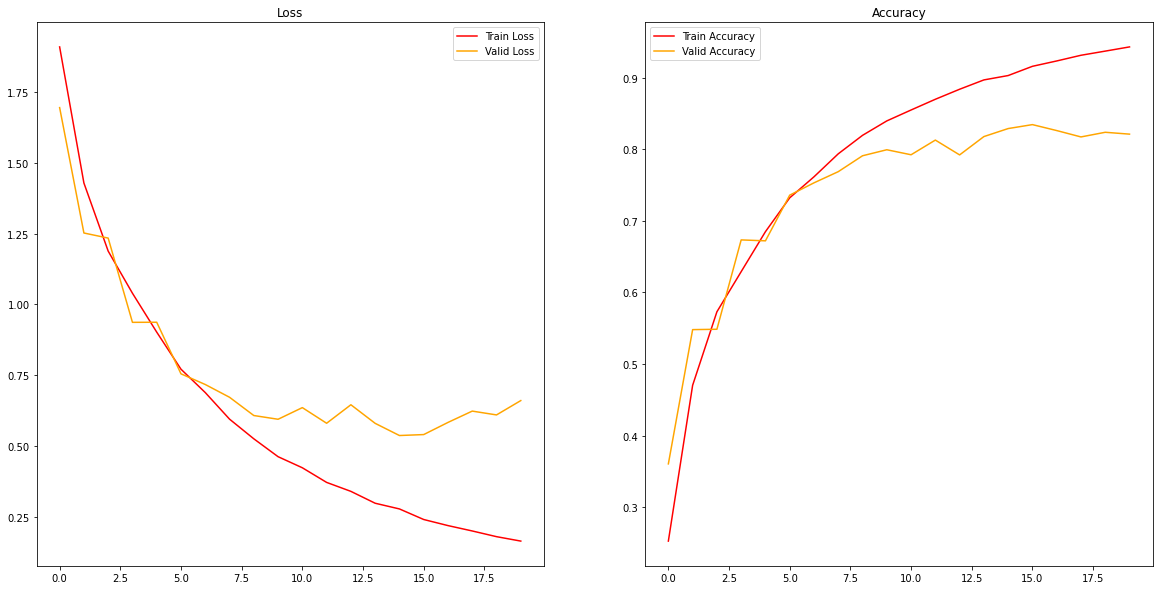

In [9]:
## Training and Validating and Testing for CIFAR-10 by EfficientNet v1
device = "cuda"
efficientnetv1_model = EfficientNetv1(n_class=10).to(device)                        # EfficientNet v1 Model for Training Version
efficientnetv1_actuator = EfficientNetv1_Actuator(model=efficientnetv1_model, loaders=loaders, opt="adam", lr=0.001, has_scheduler=False, device=device).to(device)

start_time = time.time()
efficientnetv1_actuator.train_and_valid(max_epochs=20, disp_epochs=1)
print(f"Total Training Time : {time.time() - start_time:>3f}")

efficientnetv1_actuator.test()                                                      # EfficientNet v1 Model for Testing Version

# <font color="#2F9D27"> **※ EfficientNet v1 Model Save and Load** </font>

### <font color="#2F9D27"> **① EfficientNet v1 Model Save based on Train/Valid History** </font>

In [10]:
## EfficientNet v1 Model Save
for param_tensor in efficientnetv1_model.state_dict():
    print(f"{param_tensor} : \t {efficientnetv1_model.state_dict()[param_tensor].size()}")   # EfficientNet v1 model의 state dictionary 출력 -> 각 layer에서의 parameter들

model_dir = os.path.join(os.getcwd(), "drive", "MyDrive", "Colab Notebooks", "AI Algorithm Modeling", "model")
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

torch.save(efficientnetv1_model.state_dict(), os.path.join(model_dir, "EfficientNet_v1.pth"))

input_block.0.weight : 	 torch.Size([32, 3, 3, 3])
input_block.0.bias : 	 torch.Size([32])
input_block.1.weight : 	 torch.Size([32])
input_block.1.bias : 	 torch.Size([32])
input_block.1.running_mean : 	 torch.Size([32])
input_block.1.running_var : 	 torch.Size([32])
input_block.1.num_batches_tracked : 	 torch.Size([])
a_block.input_conv.0.weight : 	 torch.Size([32, 32, 1, 1])
a_block.input_conv.0.bias : 	 torch.Size([32])
a_block.input_conv.1.weight : 	 torch.Size([32])
a_block.input_conv.1.bias : 	 torch.Size([32])
a_block.input_conv.1.running_mean : 	 torch.Size([32])
a_block.input_conv.1.running_var : 	 torch.Size([32])
a_block.input_conv.1.num_batches_tracked : 	 torch.Size([])
a_block.depthwise.0.weight : 	 torch.Size([32, 1, 3, 3])
a_block.depthwise.0.bias : 	 torch.Size([32])
a_block.depthwise.1.weight : 	 torch.Size([32])
a_block.depthwise.1.bias : 	 torch.Size([32])
a_block.depthwise.1.running_mean : 	 torch.Size([32])
a_block.depthwise.1.running_var : 	 torch.Size([32])
a_bl

### <font color="#2F9D27"> **② EfficientNet v1 Model Load and Performance Estimation** </font>

In [11]:
## EfficientNet v1 Model Load
device = "cuda"

print("========== EfficientNet v1 Test without Load ==========")    # ① 먼저 학습하지 않은 상태로 Actuator를 통해 Test dataset 성능 측정
efficientnetv1 = EfficientNetv1(n_class=10).to(device)
efficientnetv1_actuator = EfficientNetv1_Actuator(model=efficientnetv1, loaders=loaders, opt="adam", lr=0.001, has_scheduler=False, device=device).to(device)
efficientnetv1_actuator.test()

model_path = os.path.join(model_dir, "EfficientNet_v1.pth")
print(model_path)
print()

print("========== EfficientNet v1 Test with Load ==========")       # ② 이전에 학습된 Model의 parameter들을 Load한 후, Test dataset 성능 측정
efficientnetv1.load_state_dict(torch.load(model_path))
efficientnetv1.eval()

efficientnetv1_loaded_actuator = EfficientNetv1_Actuator(model=efficientnetv1, loaders=loaders, opt="adam", lr=0.001, has_scheduler=False, device=device).to(device)
efficientnetv1_loaded_actuator.test()

========== EfficientNet v1 Test without Load ==========
========== Test Start ==========
Test loss: 2.303025, Test acc: 0.100000, Test time : 25.711231
/content/drive/MyDrive/Colab Notebooks/AI Algorithm Modeling/model/EfficientNet_v1.pth

========== EfficientNet v1 Test with Load ==========
========== Test Start ==========
Test loss: 0.659678, Test acc: 0.821400, Test time : 25.451452
